In [1]:
import pandas  as pd
import numpy   as np
import xgboost as xgb


In [2]:
train_data = pd.read_csv('/content/train.csv',index_col=0)
test_data  = pd.read_csv('/content/test.csv',index_col=0)

In [3]:
xgb.__version__

'3.0.4'

In [5]:
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
X_train = train_data.select_dtypes(include=['number']).copy()
X_train = X_train.drop(['SalePrice'], axis=1)
y_train = train_data["SalePrice"]
X_test  = test_data.select_dtypes(include=['number']).copy()

In [7]:
for df in (X_train, X_test):
    df["n_bathrooms"] = df["BsmtFullBath"] + (df["BsmtHalfBath"]*0.5) + df["FullBath"] + (df["HalfBath"]*0.5)
    df["area_with_basement"]  = df["GrLivArea"] + df["TotalBsmtSF"]

In [8]:
regressor=xgb.XGBRegressor(eval_metric='rmsle')

In [9]:
from sklearn.model_selection import GridSearchCV

In [11]:
param_grid = {"max_depth": [4,5,6],
              "n_estimators" : [500,600,700],
              "learning_rate": [0.01, 0.015]}

search = GridSearchCV(regressor, param_grid, cv = 5, scoring = "neg_mean_squared_log_error").fit(X_train, y_train)

In [12]:
search_results = pd.DataFrame(search.cv_results_)
columns = [column for column in search_results if column.startswith('param_')]
columns.append("mean_test_score")
columns.append("rank_test_score")
# convert mean_test_score to RMSLE and add to table
search_results["RMSLE"] = np.sqrt(-search_results["mean_test_score"])
columns.append("RMSLE")
search_results[columns].sort_values(by='mean_test_score', ascending=False)

,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score,rank_test_score,RMSLE
11,0.015,4,700,-0.018348,1,0.135454
10,0.015,4,600,-0.018414,2,0.135699
9,0.015,4,500,-0.018600,3,0.136381
2,0.010,4,700,-0.018765,4,0.136985
14,0.015,5,700,-0.018822,5,0.137193
13,0.015,5,600,-0.018855,6,0.137314
12,0.015,5,500,-0.019018,7,0.137907
5,0.010,5,700,-0.019035,8,0.137969
1,0.010,4,600,-0.019036,9,0.137972
4,0.010,5,600,-0.019196,10,0.138551


In [13]:
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 700}


In [17]:
regressor = xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                             n_estimators = search.best_params_["n_estimators"],
                             max_depth = search.best_params_["max_depth"],
                             eval_metric = 'rmsle')
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)

In [18]:
solution   = pd.read_csv('/content/solution.csv')
y_true     = solution["SalePrice"]

from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_true, predictions) )
print("The score is %.5f" % RMSLE )

The score is 0.13914


In [19]:
output = pd.DataFrame({"Id":test_data.index, "SalePrice":predictions})
output.to_csv('submission.csv', index=False)

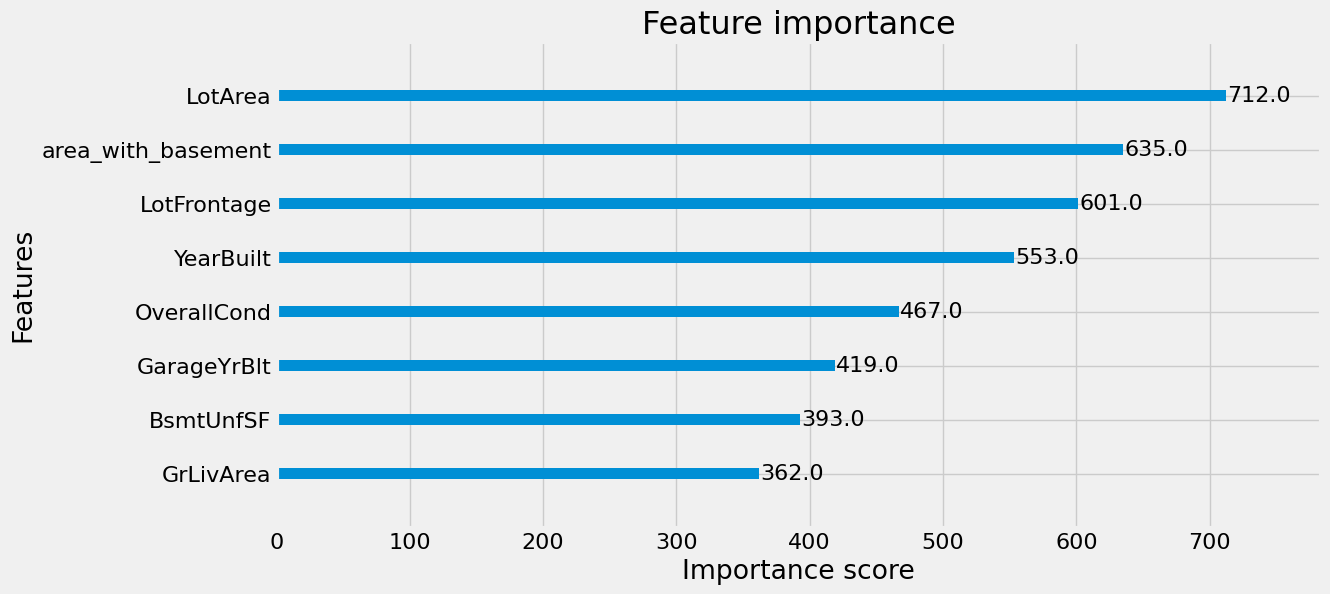

In [20]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=8, ax=ax)
plt.show();

#It is important to note that, unlike the RMSE, the RMSLE is asymmetric; penalizing much more the underestimated predictions than the overestimated predictions. For example, say the correct value is  
y[i] =1000, then underestimating by 600 is almost twice as bad as overestimating by 600:

In [21]:
def RSLE(y_hat,y):
    return np.sqrt((np.log1p(y_hat) - np.log1p(y))**2)

print("The RMSLE score is %.3f" % RSLE( 400,1000) )
print("The RMSLE score is %.3f" % RSLE(1600,1000) )

The RMSLE score is 0.915
The RMSLE score is 0.470


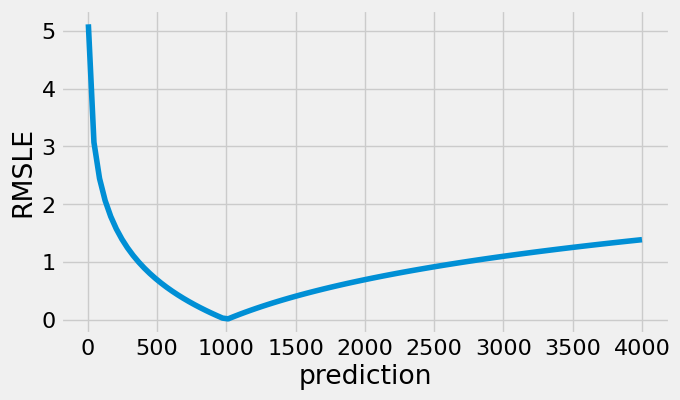

In [22]:
plt.rcParams["figure.figsize"] = (7, 4)
x = np.linspace(5,4000,100)
plt.plot(x, RSLE(x,1000))
plt.xlabel('prediction')
plt.ylabel('RMSLE')
plt.show()